In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize_scalar
from scipy import signal
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.tsa.stattools as smt

### Replication of single-run plots

In [2]:
df_1 = pd.read_csv('validation_samples/valoutput_3.csv')
df_1.head()

,GDP,GDP_growth,C,I,prices,markups,TotDebt,EnDem,U,Em,EmIndex,RD
0,442013.590916,0.838851,422993.424954,18712.092229,1.161929,0.192930,2817.651901,346785.640628,0.0056,331042.172070,100.000000,686.487189
1,447180.193740,1.065450,422727.860883,19508.981483,1.171844,0.193773,2900.826866,347072.781654,0.0060,331103.961268,100.018665,783.162253
2,449335.773977,0.678490,424724.575650,16110.494108,1.176188,0.194451,2910.048398,347821.628810,0.0064,331560.994584,100.156724,815.066537
3,445197.964584,0.689837,425047.411240,14204.718415,1.162282,0.195802,2396.609078,349417.042153,0.0048,332873.184136,100.553105,679.201927
4,442675.673174,0.156070,423611.057092,12956.698356,1.158232,0.195771,2050.660509,349645.466282,0.0048,332918.359373,100.566752,603.130441


In [3]:
T = range(len(df_1.GDP))

In [4]:
def indexnumber(ts):
    return 100 * ts / ts[0]

In [5]:
real_GDP_1 = df_1.GDP / df_1.prices

In [6]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

(Partial) replication of Lamperti et al (2018) fig 2

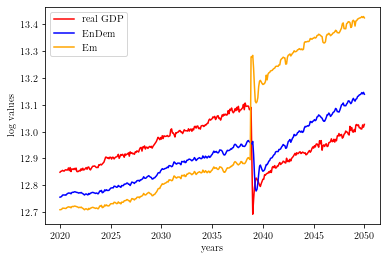

In [7]:
# fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# ax[0,0].plot(T, np.log(real_GDP_1))
# ax[0,0].set_xlabel('time')
# ax[0,0].set_ylabel('real GDP (log)')
# ax[0,0].set_title('(a) real GDP')
# ax[0,0].set_xticks(x, years)

# ax[0,1].plot(T, np.log(df_1.EnDem))
# ax[0,1].set_title('(b) energy demand')

# ax[1,0].plot(T, np.log(df_1.Em))
# ax[1,0].set_title('(c) carbon emissions')

x = np.arange(0, 361, 60)
years = np.arange(2020, 2051, 5)

plt.figure(figsize=(6,4))

plt.plot(T, np.log(real_GDP_1), label='real GDP', color='red')
plt.plot(T, np.log(df_1.EnDem), label='EnDem', color='blue')
plt.plot(T, np.log(df_1.Em), label='Em', color='orange')
plt.xticks(ticks=x, labels=years)
plt.xlabel('years')
plt.ylabel('log values')
plt.legend()

plt.show()



(Partial) replication of Lamperti et al (2018) fig 7

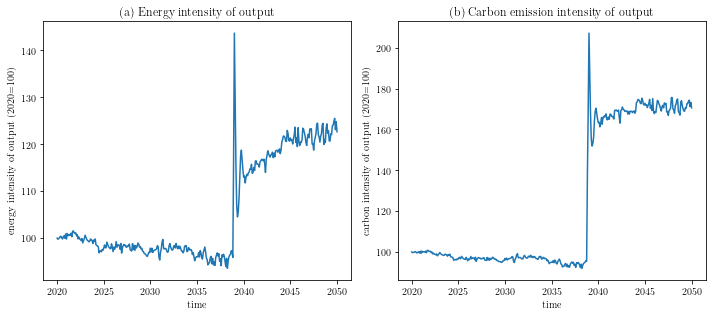

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

ax[0].plot(T, indexnumber(df_1.EnDem / real_GDP_1))
ax[0].set_xlabel('time')
ax[0].set_ylabel('energy intensity of output (2020=100)')
ax[0].set_title('(a) Energy intensity of output')
ax[0].set_xticks(x, years)

ax[1].plot(T, indexnumber(df_1.Em / real_GDP_1))
ax[1].set_xlabel('time')
ax[1].set_ylabel('carbon intensity of output (2020=100)')
ax[1].set_title('(b) Carbon emission intensity of output')
ax[1].set_xticks(x, years)

plt.tight_layout()
plt.show()

In [9]:
# bk_low = 6
# bk_high = 32
# bk_K = 12

# bk_low = 1.5
# bk_high = 8
# bk_K = 3

bk_low = 18
bk_high = 96
bk_K = 36

(Partial) replication of Lamperti et al (2018) fig 8

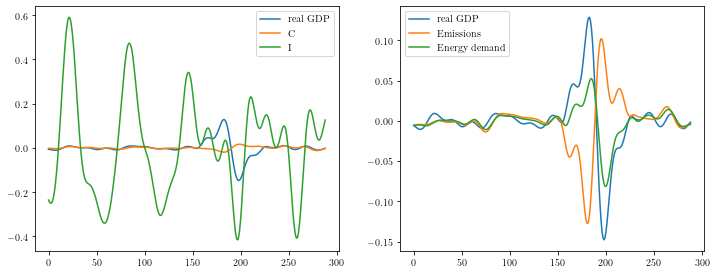

(-0.7341490575075571, 3.5484986346387326e-50)
(0.24631622782654497, 2.2890470250215157e-05)
(0.9334506945803807, 8.169660194355824e-130)
(-0.8943843715426805, 2.7694219382803757e-102)


In [10]:
gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP_1), bk_low, bk_high, bk_K)
C_filtered = sm.tsa.filters.bkfilter(np.log(df_1.C), bk_low, bk_high, bk_K)
I_filtered = sm.tsa.filters.bkfilter(np.log(df_1.I), bk_low, bk_high, bk_K)

Em_filtered = sm.tsa.filters.bkfilter(np.log(df_1.Em), bk_low, bk_high, bk_K)
EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df_1.EnDem), bk_low, bk_high, bk_K)

T_filter = range(len(gdp_filtered))

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

ax[0].plot(T_filter, gdp_filtered, label='real GDP')
ax[0].plot(T_filter, C_filtered, label='C')
ax[0].plot(T_filter, I_filtered, label='I')
ax[0].legend()

ax[1].plot(T_filter, gdp_filtered, label='real GDP')
ax[1].plot(T_filter, Em_filtered, label='Emissions')
ax[1].plot(T_filter, EnDem_filtered, label='Energy demand')
ax[1].legend()

plt.show()

print(stats.pearsonr(gdp_filtered, C_filtered))
print(stats.pearsonr(gdp_filtered, I_filtered))
print(stats.pearsonr(gdp_filtered, EnDem_filtered))
print(stats.pearsonr(gdp_filtered, Em_filtered))

Dosi et al (2017) fig 2

## Aggregate results

In [11]:
def filepath(i):
    return f'validation_samples/valoutput_{i}.csv'

In [12]:
n_MC = 10

df_list = []
for MC_i in range(1, n_MC + 1):
    df_list.append(pd.read_csv(filepath(MC_i)))
df = pd.concat(df_list)

df.head(-10)

,GDP,GDP_growth,C,I,prices,markups,TotDebt,EnDem,U,Em,EmIndex,RD
0,421315.764657,1.242769,443698.633189,13576.910396,1.354351,0.197749,4340.356571,319569.086991,0.0376,514323.351995,100.000000,1115.711327
1,421214.072122,-0.180520,443478.911465,13756.115185,1.355332,0.198362,4607.858484,319412.329838,0.0388,504522.493273,98.094417,1200.752470
2,423555.564174,0.014678,444047.132045,14664.387692,1.362890,0.199463,4187.297125,319619.623291,0.0384,504730.597902,98.134879,1212.939852
3,420181.768731,-0.684472,442776.227238,12843.663357,1.360014,0.200605,4482.592013,319093.388350,0.0392,504227.790997,98.037118,1241.631557
4,423170.480694,0.531082,443825.703973,13110.423296,1.354434,0.199527,5123.321863,317195.224403,0.0488,502346.428421,97.671324,1170.951016
...,...,...,...,...,...,...,...,...,...,...,...,...
346,408064.960126,2.467123,442851.911386,15438.139642,0.902914,0.179628,7609.920977,415456.427882,0.0444,527764.710347,108.939689,1251.244830
347,407198.672053,1.370330,441852.730490,16674.586645,0.907056,0.178043,8071.679740,417813.165568,0.0388,529499.329278,109.297744,1387.585792
348,413378.505231,1.076148,442686.735522,19711.189010,0.906977,0.179205,11268.115353,417995.537288,0.0320,529591.255935,109.316719,1447.619892
349,414291.012195,0.621597,446053.707131,15912.561873,0.911027,0.179876,14324.226761,416495.579382,0.0368,528271.437924,109.044286,1563.783957


In [13]:
real_GDP = df.GDP / df.prices

In [14]:

# gdp_growth = (1 + real_GDP.pct_change()[1:]) ** 3 - 1
gdp_growth = (real_GDP[3:] - real_GDP[:-3]) / real_GDP[:-3]

# Filter out some outliers
gdp_growth = gdp_growth[np.abs(gdp_growth) <= 0.4]


In [15]:
print(len(gdp_growth))
print(gdp_growth)

360130
0     -0.024332
0     -0.024939
0     -0.019897
0     -0.025446
0     -0.024549
         ...   
360    0.018630
360    0.017329
360    0.018220
360    0.018698
360    0.018534
Length: 360130, dtype: float64


KurtosistestResult(statistic=38.757066986966905, pvalue=0.0)


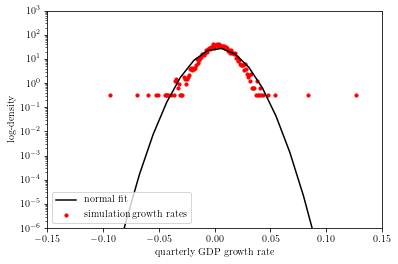

In [16]:
# g = gdp_growth[np.abs(gdp_growth) <= 0.05]

data = df.GDP_growth / 100
# data = gdp_growth

print(stats.kurtosistest(data))

# print(data)

# mu, std = norm.fit(data)

plt.figure(figsize=(6,4))
# plt.hist(gdp_growth, density=True, bins=100)
# plt.xlim(-0.2, 0.2)

# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)

# print(stats.kurtosis(gdp_growth))
x = np.linspace(-0.3, 0.3)
dens, bins, _ = plt.hist(data, 500, density=True, alpha=0.)
mu, sigma = stats.norm.fit(data)
best_fit_line = stats.norm.pdf(x, mu, sigma)
bins1 = bins[:-1]
bins2 = bins[1:]

bins = np.mean([bins1, bins2], axis=0)
plt.plot(x, best_fit_line, color='black', label='normal fit')
plt.scatter(bins, dens, s=10, c='red', label='simulation growth rates')
plt.xlim(-0.15, 0.15)
plt.ylim(10e-7, 10e2)
plt.legend(loc='lower left')
plt.xlabel('quarterly GDP growth rate')
plt.ylabel('log-density')

plt.yscale('log')

In [17]:
U_filtered = sm.tsa.filters.bkfilter(np.log(df.U), bk_low, bk_high, bk_K)
C_filtered = sm.tsa.filters.bkfilter(np.log(df.C), bk_low, bk_high, bk_K)
I_filtered = sm.tsa.filters.bkfilter(np.log(df.I), bk_low, bk_high, bk_K)
Em_filtered = sm.tsa.filters.bkfilter(np.log(df.Em), bk_low, bk_high, bk_K)
EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df.EnDem), bk_low, bk_high, bk_K)
TotDebt_filtered = sm.tsa.filters.bkfilter(np.log(df.TotDebt), bk_low, bk_high, bk_K)
prices_filtered = sm.tsa.filters.bkfilter(np.log(df.prices), bk_low, bk_high, bk_K)

(Partial) reproduction of Dosi (2017) fig 3

In [18]:
# Count recession periods
durations = []

recession = False
duration = 0

for g in df.GDP_growth:

    if g < 0:
        if recession:
            duration += 1
        else:
            recession = True
            duration = 1
        
    elif g > 0 and recession:
        recession = False
        durations += [duration]

# print(durations)

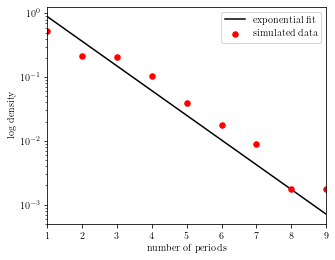

In [19]:
plt.figure(figsize=(5,4))

dens, bins, _ = plt.hist(durations, density=True, bins=max(durations), alpha=0)

loc, scale = stats.expon.fit(durations)
x = np.linspace(1, max(bins), 100)

plt.plot(x, stats.expon.pdf(x, loc, scale), label='exponential fit', c='black')
plt.scatter(np.arange(1, max(bins) + 1), dens, label='simulated data', c='red', s=30, zorder=2)
plt.xlim(1, max(bins))
plt.yscale('log')
plt.xlabel('number of periods')
plt.ylabel('log density')
plt.legend()
plt.show()

(Partial) replication of figure 4 in Lamperti et al (2018)

In [20]:
def compute_correlations(indicator, apply_bk=False, make_real=False, min_lag=-3, max_lag=3):

    all_x = []
    all_y = []

    # gdp_filtered = sm.tsa.filters.bkfilter(np.log(df_list[4].GDP / df_list[4].prices), bk_low, bk_high, bk_K)
    # Em_filtered = sm.tsa.filters.bkfilter(np.log(df_list[4].Em), bk_low, bk_high, bk_K)
    # EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df_list[4].EnDem), bk_low, bk_high, bk_K)
    # print(stats.pearsonr(gdp_filtered, EnDem_filtered))
    # print(stats.pearsonr(gdp_filtered, Em_filtered))

    for df_part in df_list:

        # Apply filter
        real_GDP =  df_part['GDP'].to_numpy() / df_part['prices'].to_numpy()
        gdp_filtered = sm.tsa.filters.bkfilter(real_GDP, bk_low, bk_high, bk_K)

        # Prepare data
        ind_data = df_part[indicator].to_numpy()
        
        if make_real:
            ind_data = ind_data / df_part['prices'].to_numpy()

        if apply_bk:
            ind_data = sm.tsa.filters.bkfilter(ind_data, bk_low, bk_high, bk_K)
            if indicator == 'Em':
                print(f"     {indicator}: {stats.pearsonr(gdp_filtered, ind_data)}")


        all_x.extend(ind_data)
        all_y.extend(gdp_filtered)

    # print(all_x)
    # print(all_y)

    ccf_back = smt.ccf(all_x[::-1], all_y[::-1])[1:-min_lag+1][::-1]
    ccf_forw = smt.ccf(all_x, all_y)[:max_lag+1]

    ccf = np.concatenate((ccf_back, ccf_forw))

    # print(indicator)
    # print(ccf)
    
    return ccf

    # r, p = stats.pearsonr(all_x, all_y)
    # all_r.append(r)
    # all_p.append(p)
        
    # return all_r, all_p

compute_correlations('Em', apply_bk=True, make_real=True, min_lag=-12, max_lag=12)

     Em: (-0.005422448037016417, 0.9268706211376133)
     Em: (0.344847705321553, 1.714739147042085e-09)
     Em: (-0.3300841447121701, 8.974891094934181e-09)
     Em: (-0.49791894075827603, 1.6392120973854222e-19)
     Em: (0.324432832287574, 1.653000501132183e-08)
     Em: (-0.39333014097208624, 3.93941837094105e-12)
     Em: (-0.2197447514968425, 0.0001661498608662885)
     Em: (0.5420431947215686, 1.7997747941607658e-23)
     Em: (-0.034169120966543946, 0.5629086624440515)
     Em: (0.19675804264428495, 0.0007700908442116343)


array([-0.15549668, -0.20177023, -0.24641049, -0.28664822, -0.31979811,
       -0.34347532, -0.35577779, -0.35545022, -0.34200194, -0.31575252,
       -0.27783778, -0.2301399 , -0.17516974, -0.11504092, -0.05368631,
        0.00556675,  0.05961747,  0.10579597,  0.14206109,  0.16711771,
        0.18047901,  0.18247396,  0.17417113,  0.1572707 ,  0.13393697])

     Em: (-0.005422448037016417, 0.9268706211376133)
     Em: (0.344847705321553, 1.714739147042085e-09)
     Em: (-0.3300841447121701, 8.974891094934181e-09)
     Em: (-0.49791894075827603, 1.6392120973854222e-19)
     Em: (0.324432832287574, 1.653000501132183e-08)
     Em: (-0.39333014097208624, 3.93941837094105e-12)
     Em: (-0.2197447514968425, 0.0001661498608662885)
     Em: (0.5420431947215686, 1.7997747941607658e-23)
     Em: (-0.034169120966543946, 0.5629086624440515)
     Em: (0.19675804264428495, 0.0007700908442116343)


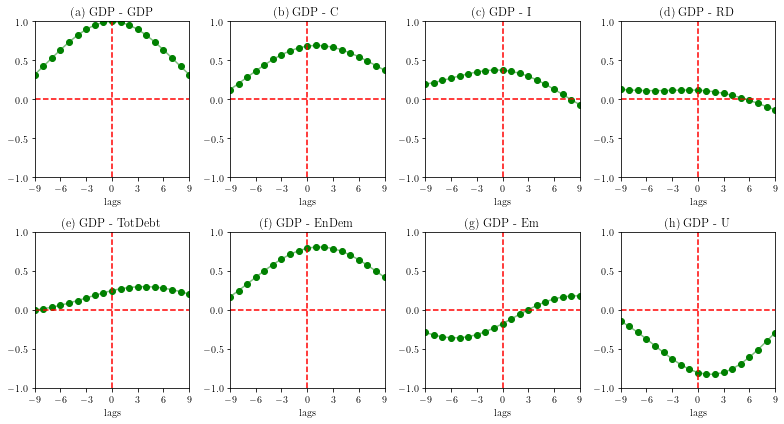

In [27]:
lags = 9
min_lag = -lags
max_lag = lags

indicators = ['GDP', 'C', 'I', 'RD', 'TotDebt', 'EnDem', 'Em', 'U']
lags = np.arange(min_lag, max_lag + 1)

fig, axes = plt.subplots(2,4, figsize=(11, 6))

for i, (indicator, ax) in enumerate(zip(indicators, axes.flatten())):

    fig_nr = chr(i + 97)

    apply_bk = True
    make_real = True
    if indicator == ('markups' or 'U' or 'EnDem' or 'Em'):
        make_real=False

    all_r = compute_correlations(indicator, apply_bk=apply_bk, make_real=make_real,
                                        min_lag=min_lag, max_lag=max_lag)

    ax.hlines(0, min_lag, max_lag, linestyle='dashed', color='red')
    ax.vlines(0, -1., 1, linestyle='dashed', color='red')

    ax.scatter(lags, all_r, color='green')
    ax.plot(lags, all_r, alpha=0.5, color='green')

    ax.set_ylim(-1., 1.)
    ax.set_xlim(min_lag, max_lag)
    ax.set_xticks(np.linspace(min_lag, max_lag, 7))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_title(f'({fig_nr}) GDP - {indicator}')
    ax.set_xlabel('lags')

plt.tight_layout()
plt.show()

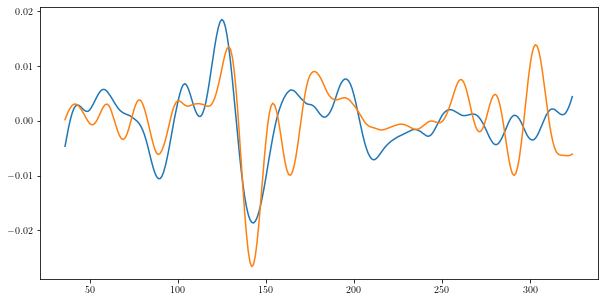

(0.5919498625558393, 1.0276641472941777e-28)


In [22]:
real_GDP_0 = df_list[0].GDP / df_list[0].prices

real_GDP_0 = sm.tsa.filters.bkfilter(np.log(real_GDP_0), bk_low, bk_high, bk_K)
Em_filtered = sm.tsa.filters.bkfilter(np.log(df_list[0].Em), bk_low, bk_high, bk_K)
# cycle_gdp, trend_gdp = sm.tsa.filters.hpfilter(real_GDP_0, 129600)
# cycle_em, trend_cm = sm.tsa.filters.hpfilter(df_list[0].Em, 129600)

plt.figure(figsize=(10, 5))

plt.plot(real_GDP_0)
plt.plot(Em_filtered)
# plt.plot(cycle_gdp)
# plt.plot(cycle_em)

plt.show()

print(stats.pearsonr(real_GDP_0, Em_filtered))

(0.022078955162997297, 0.1848084446887463)


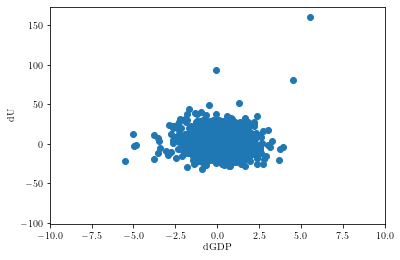

In [23]:
dGDP = 100 * (df.GDP / df.prices).pct_change()
dEm = 100 * df.Em.pct_change()
dEnDem = 100 * df.EnDem.pct_change()
dU = 100 * df.U.pct_change()

# plt.scatter(dGDP, dEm)
# plt.scatter(dGDP, dEnDem)
plt.scatter(dGDP, dU)
# plt.ylim(-3, 3)
plt.xlabel('dGDP')
plt.ylabel('dU')
plt.xlim(-10, 10)

print(stats.pearsonr(dGDP[1:], dU[1:]))

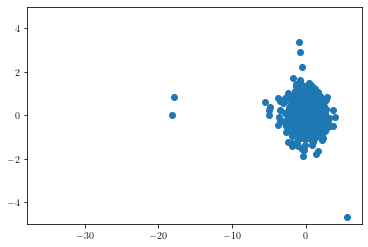

In [24]:
plt.scatter(dGDP, dEnDem)
plt.ylim(-5, 5)
plt.show()

In [25]:
df.corr()

,GDP,GDP_growth,C,I,prices,markups,TotDebt,EnDem,U,Em,EmIndex,RD
GDP,1.000000,0.102203,-0.135037,0.248755,0.279770,0.694331,-0.162953,-0.234195,-0.259246,-0.799642,-0.112540,-0.567645
GDP_growth,0.102203,1.000000,0.019698,0.202216,-0.021996,-0.065269,-0.015992,-0.020417,0.137071,-0.028490,-0.055254,0.012124
C,-0.135037,0.019698,1.000000,0.196519,-0.097842,-0.211890,0.488276,0.203571,0.049132,0.502617,0.193020,0.582408
I,0.248755,0.202216,0.196519,1.000000,-0.301459,-0.011832,0.450255,0.351624,-0.175808,0.120959,0.199606,0.448678
prices,0.279770,-0.021996,-0.097842,-0.301459,1.000000,0.280608,-0.490229,-0.932294,-0.152728,-0.413653,-0.402150,-0.428893
markups,0.694331,-0.065269,-0.211890,-0.011832,0.280608,1.000000,-0.293698,-0.186513,0.222952,-0.539208,0.323589,-0.525368
TotDebt,-0.162953,-0.015992,0.488276,0.450255,-0.490229,-0.293698,1.000000,0.532110,0.004946,0.440220,0.257762,0.640865
EnDem,-0.234195,-0.020417,0.203571,0.351624,-0.932294,-0.186513,0.532110,1.000000,0.171447,0.506724,0.585898,0.474478
U,-0.259246,0.137071,0.049132,-0.175808,-0.152728,0.222952,0.004946,0.171447,1.000000,0.245859,0.518946,0.146915
Em,-0.799642,-0.028490,0.502617,0.120959,-0.413653,-0.539208,0.440220,0.506724,0.245859,1.000000,0.396382,0.804210


In [26]:
filtered_series ={
    'GDP': sm.tsa.filters.bkfilter(np.log(df.GDP / df.prices), bk_low, bk_high, bk_K),
    '$\\hat{\\mu}$': sm.tsa.filters.bkfilter(df.markups, bk_low, bk_high, bk_K),
    'I': I_filtered.to_numpy(),
    'C': C_filtered.to_numpy(),
    'U': U_filtered.to_numpy(),
    'TotDebt': TotDebt_filtered.to_numpy(),
    'EnDem': EnDem_filtered.to_numpy(),
    'Em': Em_filtered.to_numpy()
}

df_filtered = pd.DataFrame(filtered_series)

ValueError: All arrays must be of the same length

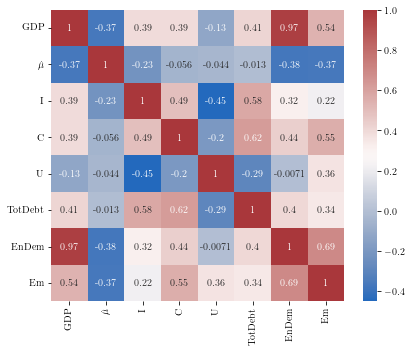

In [ ]:
import seaborn as sb
# corr = df.corr()

plt.figure(figsize=(6,5))

sb.heatmap(df_filtered.corr(), cmap="vlag", annot=True)

plt.tight_layout()
plt.show()